## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [7]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

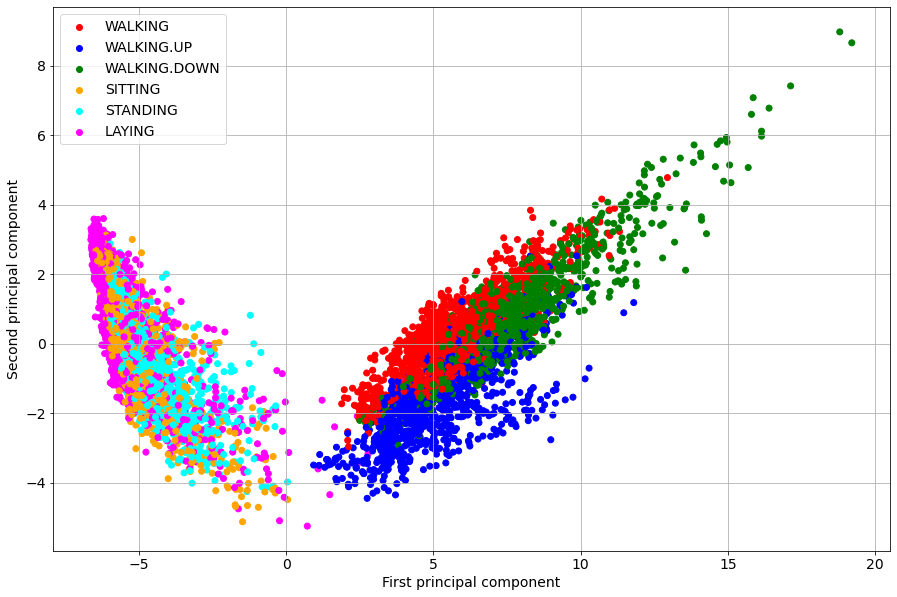

In [8]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [9]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


Dataset is now located at: ./UCI HAR Dataset/


In [10]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(2947, 128, 9) (2947, 1) 0.09913992 0.39567086
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [40]:
class HarClassifier(nn.Module):
    def __init__(self, in_channels, num_classes, sequence_len):
        super().__init__()
        new_len = sequence_len
        for sz in [5, 3, 3, 2]:
            new_len -= sz - 1
            new_len //= 2
        self.network = nn.Sequential(
            nn.Conv1d(in_channels, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
#             nn.Conv1d(8, 16, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),
#             nn.Conv1d(16, 32, kernel_size=3),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),
#             nn.Conv1d(32, 64, kernel_size=2),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2),
            nn.Linear(new_len, num_classes)
        )

    def get_optimizer(self):
        return torch.optim.Adam(self.network.parameters(), lr = 1e-3)
        
    
    def forward(self, X):
        return self.network(X)

In [41]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [42]:
def make_train_torch(n_epoch, X, Y, batch_size, net, criterion, optimizer):
    loss_history = []
    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

           # net.zeroGradParameters()

            # Forward
            predictions = net.forward(torch.tensor(x_batch))
            loss = criterion(predictions, torch.tensor(np.argmax(y_batch, axis = 1)))

            # Backward
            #dp = criterion.backward(predictions, torch.tensor(y_batch))
            loss.backward()

            # Update weights
            optimizer.step() 
            optimizer.zero_grad()

            loss_history.append(loss)
    return loss_history


In [43]:
print(X_train.shape[2])

9


In [44]:
batch_size = 128
n_epoch = 100
criterion = torch.nn.functional.nll_loss
model = HarClassifier(X_train.shape[2], 6, X_train.shape[1])

In [45]:
loss = make_train_torch(n_epoch, X_train, y_train, batch_size, model, criterion, model.get_optimizer())

RuntimeError: Given groups=1, weight of size [16, 9, 5], expected input[128, 128, 9] to have 9 channels, but got 128 channels instead

In [6]:
# Your experiments here

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
# Your experiments here